In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

from LDA import LDA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import colormaps, cm

import warnings
warnings.filterwarnings('ignore')

### Load data

In [2]:
data_train = np.load('data/fashion_train.npy', mmap_mode='r')
data_test = np.load('data/fashion_test.npy', mmap_mode='r')

In [3]:
X_train = data_train[:, :-1]
y_train = data_train[:, -1]

X_test = data_test[:, :-1]
y_test = data_test[:, -1]

In [4]:
clf = LDA(n_components=2)
clf.fit(X_train, y_train)

X_train_transformed = clf.transform(X_train)
X_test_transformed = clf.transform(X_test)

### Gaussian KDE

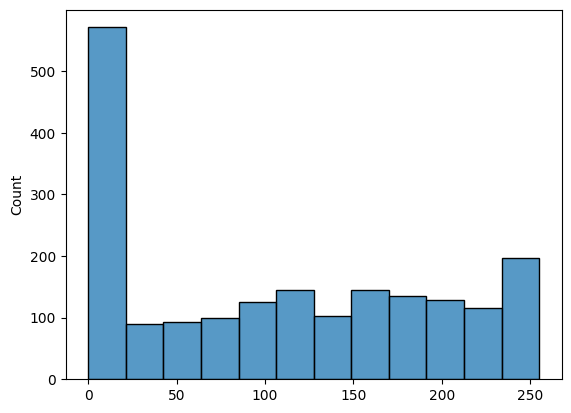

In [5]:
fig, ax = plt.subplots();

x=X_train[y_train==1][:,345]

sns.histplot(x);

In [6]:
kernel=stats.gaussian_kde(x.T)

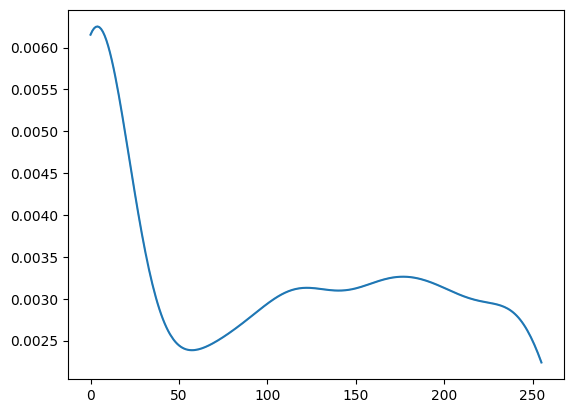

In [7]:
x1 = kernel.pdf(x)
sns.lineplot(x=x, y=x1);

### Build classifier

In [8]:
class NaiveBayes():
    def __init__(self, h, pdf_estimator_method):
        self.h = h # Step size in histogram
        self.pdf_estimator_method = pdf_estimator_method # Type of pdf-estimator: hist or kde

        self.class_labels = None # Save class labels
        self.priors = None # Save prior class probabilities
        self.pdf_estimator = None # Save 

    def histogram_cl(self, x):
        '''
        Return histogram for a given feature in a given class.
        '''
        bins = int(np.ceil((max(x)-min(x)) / self.h))
        density_values, upper_bound = np.histogram(x, bins=bins, density=True)

        histogram = list(zip(density_values, upper_bound))

        return histogram

    def fit_pdf_estimator(self, X, y):
        ''' 
        Estimate the conditional probability density function for each
        predictor in each class, using either histograms or a gaussian
        kernel density estimate.
        '''
        pdf_estimator = {}

        for cl in self.class_labels:
            # Method: Histogram
            if self.pdf_estimator_method == 'hist':                
                pdf_estimator[cl] = [self.histogram_cl(x) for x in X[y==cl].T]

            # Method: Kernel density estimate
            elif self.pdf_estimator_method == 'kde':
                pdf_estimator[cl] = [stats.gaussian_kde(x, self.h) for x in X[y==cl].T]

            else:
                raise ValueError('Type of pdf estimator is not available.')

        return pdf_estimator

    def fit(self, X, y):
        '''
        Fit  the classifier.
        '''
        self.class_labels = np.unique(y)
        n = X.shape[0]

        # Prior class probabilities
        self.priors = {cl: sum(y==cl)/n for cl in self.class_labels}

        # Fit the pdf estimator for each predictor in each class
        self.pdf_estimator = self.fit_pdf_estimator(X, y)

    def pdf(self, cl, i, p):
        '''
        Uses the pdf estimator to find the class conditional probability
        for the predictor.
        '''
        # Method: Histogram
        if self.pdf_estimator_method == 'hist':
            for d, upper_bound in self.pdf_estimator[cl][i]:
                if p < upper_bound:
                    return d
            return d
        
        # Method: Kernel density estimate
        elif self.pdf_estimator_method == 'kde':
            return self.pdf_estimator[cl][i].pdf(p)
            
        else:
            raise ValueError('Type of pdf estimator is not available.')

    def class_conditional_pdf(self, x, cl):
        '''
        Return the class coniditional probabilities for each class for a
        given instance.
        '''
        class_conditionals = [self.pdf(cl, i, p) for i, p in enumerate(x)] 
        return class_conditionals

    def predict_proba(self, X):
        '''
        Returns the posterior probability for each class for each instance.
        '''
        n, K = X.shape[0], len(self.priors)

        # For each sample compute the posterior probabilities for all classes           
        posteriors = np.empty((n, K))
        for i in range(n):

            # Compute the likelihood for each class
            likelihoods = []
            for cl in self.class_labels:
                # Get prior probability and conditional probabilities for the class
                prior = self.priors[cl]
                class_conditional = self.class_conditional_pdf(X[i], cl)

                # Multiply the prior probability for the class with the conditional probability for each feature
                likelihood = prior * np.prod(class_conditional)
            
                # Save the likelihood for each class
                likelihoods.append(likelihood)
                            
            # Normalize likelihoods to get posteriors
            posteriors[i] = likelihoods/np.sum(likelihoods)

        return posteriors

    def predict(self, X):
        '''
        Returns the predicted class for each instance.
        '''

        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=1)

### Cross validation

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, confusion_matrix

In [10]:
def cross_validate(clfs, H, X, y):
    accuracy_scores, recall_scores, precision_scores, roc_auc_scores  = [], [], [], []

    for clf in clfs:
        accuracy, recall, precision, roc_auc = 0, 0, 0, 0

        num_folds = 10
        skf = StratifiedKFold(num_folds, random_state=0, shuffle=True)

        for (train_idx, val_idx) in skf.split(X,y):
            clf.fit(X[train_idx], y_train[train_idx])
            y_hat = clf.predict(X[val_idx])
            y_hat_proba = clf.predict_proba(X[val_idx])
            y_true = y[val_idx]

            accuracy += accuracy_score(y_true, y_hat)
            recall += recall_score(y_true, y_hat, average = 'macro')
            precision += precision_score(y_true, y_hat, average = 'macro')
            roc_auc += roc_auc_score(y_true, y_hat_proba, average = 'macro', multi_class = 'ovr')

        # Average scores
        accuracy /= num_folds
        recall /= num_folds
        precision /= num_folds
        roc_auc /= num_folds

        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        precision_scores.append(precision)
        roc_auc_scores.append(roc_auc)

    test_scores = pd.DataFrame({'Stepsize': H, 'Accuracy': accuracy_scores, 'Recall': recall_scores, 'Precision': precision_scores, 'Roc_auc': roc_auc_scores})
    return test_scores

In [11]:
H = np.arange(start=0.1, stop=1.1, step=0.1)

classifiers_hist = [NaiveBayes(h,'hist') for h in H]
classifiers_kde = [NaiveBayes(h,'kde') for h in H]

In [12]:
scores_hist = cross_validate(classifiers_hist, H, X_train_transformed, y_train)
scores_kde = cross_validate(classifiers_kde, H, X_train_transformed, y_train)

#### Using histogram

In [13]:
value = scores_hist[['Accuracy', 'Recall', 'Precision', 'Roc_auc']].max()
idx = scores_hist[['Accuracy', 'Recall', 'Precision', 'Roc_auc']].idxmax()
stepsize = scores_hist['Stepsize'].iloc[idx]

d = {'Stepsize': list(stepsize), 'Value': value}
max_scores_hist = pd.DataFrame(d)

In [14]:
value = scores_kde[['Accuracy', 'Recall', 'Precision', 'Roc_auc']].max()
idx = scores_kde[['Accuracy', 'Recall', 'Precision', 'Roc_auc']].idxmax()
stepsize = scores_kde['Stepsize'].iloc[idx]

d = {'Stepsize': list(stepsize), 'Value': value}
max_scores_kde = pd.DataFrame(d)

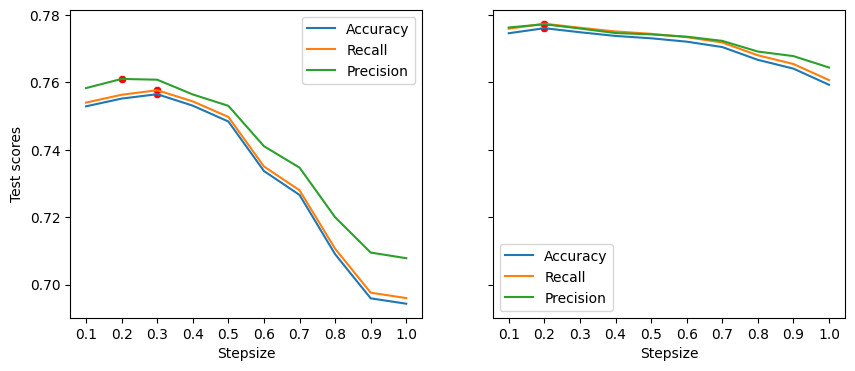

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# Plot accuracy, recall, and precision
sns.lineplot(data=scores_hist,  x='Stepsize', y='Accuracy', label='Accuracy', ax=ax[0])
sns.lineplot(data=scores_hist,  x='Stepsize', y='Recall', label='Recall', ax=ax[0])
sns.lineplot(data=scores_hist,  x='Stepsize', y='Precision', label='Precision', ax=ax[0])

sns.lineplot(data=scores_kde,  x='Stepsize', y='Accuracy', label='Accuracy', ax=ax[1])
sns.lineplot(data=scores_kde,  x='Stepsize', y='Recall', label='Recall', ax=ax[1])
sns.lineplot(data=scores_kde,  x='Stepsize', y='Precision', label='Precision', ax=ax[1])

# Plot points for max scores
sns.scatterplot(data=max_scores_hist[:3], x='Stepsize', y='Value', color='red', ax=ax[0])
sns.scatterplot(data=max_scores_kde[:3], x='Stepsize', y='Value', color='red', ax=ax[1])

ax[0].set_ylabel('Test scores')

ax[0].set_xticks(H);
ax[1].set_xticks(H);

plt.savefig('NB_test_scores')

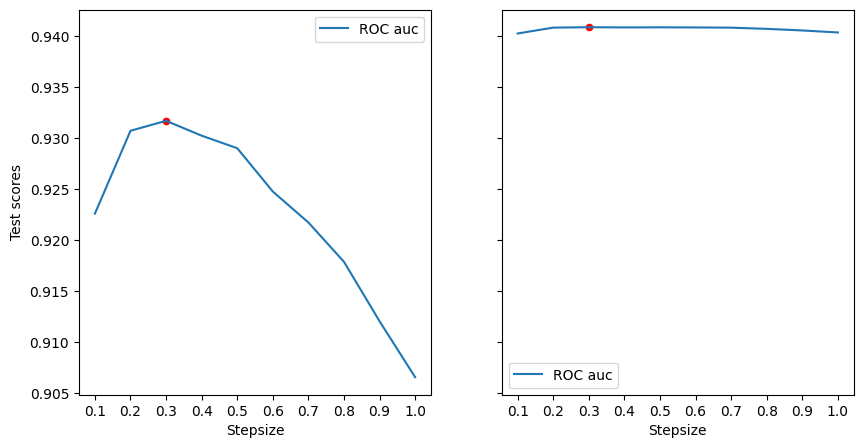

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)

# Plot ROC auc
sns.lineplot(data=scores_hist,  x='Stepsize', y='Roc_auc', label='ROC auc', ax=ax[0])
sns.scatterplot(data=max_scores_hist[3:4], x='Stepsize', y='Value', color='red', ax=ax[0])

sns.lineplot(data=scores_kde,  x='Stepsize', y='Roc_auc', label='ROC auc', ax=ax[1])
sns.scatterplot(data=max_scores_kde[3:4], x='Stepsize', y='Value', color='red', ax=ax[1])

ax[0].set_ylabel('Test scores')

ax[0].set_xticks(H);
ax[1].set_xticks(H);

plt.savefig('NB_ROCauc_score')

We chose the Gaussian Kernel and stepsize=0.2.

### Training of final classifier

In [34]:
NB = NaiveBayes(0.2,'kde')
NB.fit(X_train_transformed, y_train)

yhat = NB.predict(X_test_transformed)
yhat_proba = NB.predict_proba(X_test_transformed)

### Test

In [ ]:
_confusion_matrix=confusion_matrix(y_test, yhat)
_confusion_matrix

In [80]:
test_scores = {'Class':[], 'Recall': [], 'Precision': []}

for i in range(5):
    TP = _confusion_matrix[i,i]
    FP = sum(_confusion_matrix[:,i])-TP
    FN = sum(_confusion_matrix[i,:])-TP
    TN = np.sum(_confusion_matrix)- TP-FP-FN

    test_scores['Class'].append(i)

    # Recall: TP/(TP+FN)
    test_scores['Recall'].append(TP/(TP+FN))
    # Precision: TP/(TP+FP)
    test_scores['Precision'].append(TP/(TP+FP))

In [83]:
test_scores_df = pd.DataFrame(test_scores)
test_scores_df

,Class,Recall,Precision
0,0,0.739,0.592147
1,1,0.950,0.971370
2,2,0.758,0.728146
3,3,0.806,0.803589
4,4,0.382,0.523288


### Visualization

In [19]:
d = {'LDA1':X_train_transformed[:,0], 'LDA2':X_train_transformed[:,1]}
X = pd.DataFrame(d)
y=y_train

In [22]:
# Step size in grid
h = 0.2

# Create a grid
x_min, x_max = X['LDA1'].min() - 1, X['LDA1'].max() + 1
y_min, y_max = X['LDA2'].min() - 1, X['LDA2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Define classifier
clf = NaiveBayes(h=0.2, pdf_estimator_type='kde')
clf.fit(X_train_transformed, y)

# Plot decision regions
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

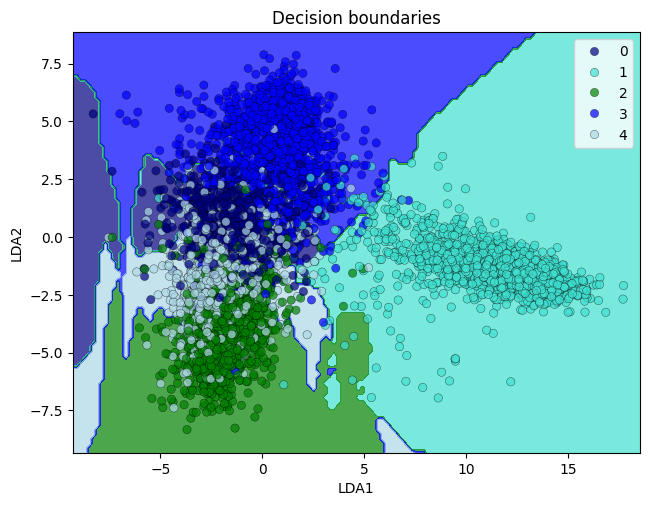

In [26]:
# Define subplots
fig, ax = plt.subplots()
plt.tight_layout();

cmap_light = ListedColormap(["navy", "turquoise", "green", 'blue', 'lightblue']) #ListedColormap(['navy','b','cornflowerblue','skyblue','lightsteelblue'])

# Plot decision boundery
ax.contourf(xx, yy, Z, 4, alpha=0.7, cmap=cmap_light)

# Plot also the training points
sns.scatterplot(x='LDA1', y="LDA2", hue=y, data=X, palette=cmap_light, alpha=0.7, edgecolor="black", linewidth=0.3, ax=ax)
ax.set_title('Decision boundaries');

plt.savefig('NB_DecisionBoundaries')